In [ ]:
# If the file is stored in Google Drive, mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Define sales buckets
def create_sales_bucket(value):
    if value < 5:
        return "0-4"
    elif value < 10:
        return "5-9"
    elif value < 20:
        return "10-19"
    elif value < 30:
        return "20-29"
    elif value < 40:
        return "30-39"
    else:
        return "40+"


data = pd.read_csv("/content/drive/MyDrive/My_DataMining_notes/project/Final data/preprocessed_data.csv")
data.info()


# Feature engineering
data["date"] = pd.to_datetime(data["date"], errors="coerce")

# Sort the data by store_nbr, item_nbr, and date
data = data.sort_values(by=["store_nbr", "item_nbr", "date"]).reset_index(drop=True)

# Define parameters
N = 7  # Number of past days to consider
target = "unit_sales"

# Step 1: Feature Engineering
# Temporal Features
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day_of_week"] = data["date"].dt.dayofweek
data["week_of_year"] = data["date"].dt.isocalendar().week
data["is_weekend"] = data["day_of_week"].isin([5, 6]).astype(int)

# Create lag features for past N days
for lag in range(1, N + 1):
    # Unit Sales Lag: Fill NaN with 0
    data[f"unit_sales_lag_{lag}"] = (
        data.groupby(["store_nbr", "item_nbr"])[target]
        .shift(lag)
        .fillna(0)  # Fill NaN with 0
    )

    # Oil Price Lag: Fill NaN with the previous valid value (forward fill within each store group)
    data[f"oil_price_lag_{lag}"] = (
        data.groupby(["store_nbr"])["oil_price"].shift(lag).ffill().bfill()
    )

# Rolling Statistics: Ensure correct index alignment
rolling_sales = (
    data.groupby(["store_nbr", "item_nbr"])[target]
    .rolling(N)
    .agg(["mean", "std"])
    .reset_index(level=["store_nbr", "item_nbr"], drop=True)
)

# Add rolling statistics back to the original DataFrame
data["rolling_sales_mean"] = rolling_sales["mean"].fillna(0)
data["rolling_sales_std"] = rolling_sales["std"].fillna(0)


string_columns = data.select_dtypes(include=["object"]).columns
label_encoders = {}
for col in string_columns:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])

print("\nString attributes converted to class features:")


train_end_date = "2017-06-01"
test_start_date = "2017-06-01"

# Split the dataset into train and test based on the date
train_df = data[data["date"] <= train_end_date]
filtered_test_df = data[data["date"] >= test_start_date]

# Find unique item-store pairs in the train set
train_item_store_pairs = set(zip(train_df["item_nbr"], train_df["store_nbr"]))

# Filter the test set to include only item-store pairs present in the train set
test_df = filtered_test_df[
    filtered_test_df.apply(
        lambda x: (x["item_nbr"], x["store_nbr"]) in train_item_store_pairs, axis=1
    )
]

# Identify test rows excluded by the filter
missing_test_rows = filtered_test_df[
    ~filtered_test_df.apply(
        lambda x: (x["item_nbr"], x["store_nbr"]) in train_item_store_pairs, axis=1
    )
]

# Add the missing test rows back to the train set
train_df = pd.concat([train_df, missing_test_rows], ignore_index=True)


# Apply to train and test datasets
train_df["sales_bucket"] = train_df["unit_sales"].apply(create_sales_bucket)
test_df["sales_bucket"] = test_df["unit_sales"].apply(create_sales_bucket)

# Drop the original unit_sales column
train_df = train_df.drop(columns=["unit_sales"])
test_df = test_df.drop(columns=["unit_sales"])

# Set the new target variable
target = "sales_bucket"

from autogluon.tabular import TabularPredictor

train_df = train_df.drop(columns=["date", "id"])  # Drop non-predictive columns
test_df = test_df.drop(columns=["date", "id"])

# Train AutoGluon classification model
predictor = TabularPredictor(label=target, problem_type="multiclass").fit(
    train_data=train_df,
    presets="best_quality",  # High-quality training
    time_limit=1800,  # Training time in seconds
)

# Save the model
predictor.save("autogluon_unit_sales_classifier")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99995 entries, 0 to 99994
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   99995 non-null  int64  
 1   date                 99995 non-null  object 
 2   store_nbr            99995 non-null  int64  
 3   item_nbr             99995 non-null  int64  
 4   unit_sales           99995 non-null  float64
 5   onpromotion          99995 non-null  int64  
 6   transactions         99995 non-null  float64
 7   holiday_type         99995 non-null  object 
 8   holiday_scope        99995 non-null  object 
 9   location             99995 non-null  object 
 10  transferred          99995 non-null  int64  
 11  holiday_description  99995 non-null  object 
 12  oil_price            99995 non-null  float64
 13  family               99995 non-null  object 
 14  perishable           99995 non-null  int64  
 15  store_city           99995 non-null 

<ipython-input-1-2955dc9aca08>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["sales_bucket"] = test_df["unit_sales"].apply(create_sales_bucket)
No path specified. Models will be saved in: "AutogluonModels/ag-20241207_091527"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       11.00 GB / 12.67 GB (86.8%)
Disk Space Avail:   74.21 GB / 107.72 GB (68.9%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is 

In [ ]:
# !zip -r classification_model.zip ./AutogluonModels/

In [2]:
import pandas as pd
from autogluon.tabular import TabularPredictor
# Load the saved model
predictor = TabularPredictor.load("/content/AutogluonModels/ag-20241207_091527")

In [ ]:
# Evaluate performance on the test dataset
performance = predictor.evaluate(train_df)

# Print performance metrics
print("Model Performance:")
print(performance)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Model Performance:
{'accuracy': 0.6333934524785484, 'balanced_accuracy': 0.35263780965131225, 'mcc': 0.34399128298993964}


In [ ]:
# Evaluate performance on the test dataset
performance = predictor.evaluate(test_df)

# Print performance metrics
print("Model Performance:")
print(performance)

Model Performance:
{'accuracy': 0.600117508813161, 'balanced_accuracy': 0.3486485921829861, 'mcc': 0.2964575599333103}


In [ ]:
# Leaderboard for individual model performance
leaderboard = predictor.leaderboard(test_df, extra_info=True)
print(leaderboard)

                    model  score_test  score_val eval_metric  pred_time_test  \
0  NeuralNetFastAI_BAG_L2    0.600940   0.578838    accuracy       23.115703   
1     WeightedEnsemble_L3    0.600118   0.578915    accuracy       23.119369   
2       LightGBMXT_BAG_L1    0.599882   0.575679    accuracy        5.567982   
3     WeightedEnsemble_L2    0.599882   0.575679    accuracy        5.571578   
4  NeuralNetFastAI_BAG_L1    0.597767   0.574411    accuracy        1.565585   
5       LightGBMXT_BAG_L2    0.562515   0.560737    accuracy       21.169624   
6         LightGBM_BAG_L1    0.557932   0.558529    accuracy        0.121728   
7   KNeighborsUnif_BAG_L1    0.534078   0.532076    accuracy        8.099560   
8   KNeighborsDist_BAG_L1    0.520682   0.511843    accuracy        5.459143   

   pred_time_val     fit_time  pred_time_test_marginal  \
0     158.263663  1081.517579                 2.301704   
1     158.294966  1085.948724                 0.003666   
2       8.960575   135.02

In [ ]:
leaderboard = leaderboard.rename(columns={'score_test': 'accuracy'})
sorted_leaderboard = leaderboard.sort_values(by='accuracy', ascending=False)

# Display sorted leaderboard
print("Sorted Model Leaderboard:")
print(sorted_leaderboard[['model', 'accuracy']])

Sorted Model Leaderboard:
                    model  accuracy
0  NeuralNetFastAI_BAG_L2  0.600940
1     WeightedEnsemble_L3  0.600118
2       LightGBMXT_BAG_L1  0.599882
3     WeightedEnsemble_L2  0.599882
4  NeuralNetFastAI_BAG_L1  0.597767
5       LightGBMXT_BAG_L2  0.562515
6         LightGBM_BAG_L1  0.557932
7   KNeighborsUnif_BAG_L1  0.534078
8   KNeighborsDist_BAG_L1  0.520682


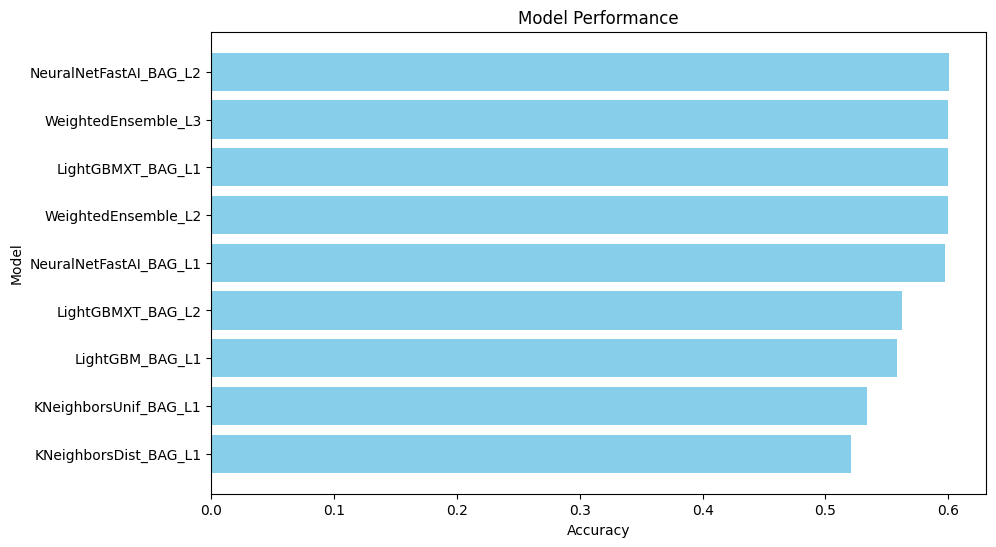

In [ ]:
import matplotlib.pyplot as plt

# Replace 'score_test' with the actual metric column name
plt.figure(figsize=(10, 6))
plt.barh(sorted_leaderboard['model'], sorted_leaderboard['score_test'], color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Model Performance')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()